In [1]:
import numpy as np
import xarray as xr
import scipy.ndimage as ndimage
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import metpy.calc as mpcalc
from metpy.units import units
from datetime import datetime

In [2]:
# Get dataset from NOMADS Server
ds = xr.open_dataset('http://nomads.ncep.noaa.gov:80/dods/gfs_0p25_1hr/gfs20201121/gfs_0p25_1hr_12z')

# Select desired vars
ds = ds[['hgtprs', 'prmslmsl', 'ugrd10m', 'vgrd10m']]

# Select time
ds = ds.sel(time=ds.time[0])

# Select level
ds = ds.sel(lev=[1000, 500])

# Select lat/lon slice
ds = ds.sel(lon=slice(220, 310), lat=slice(15, 65))

ds

<xarray.Dataset>
Dimensions:   (lat: 201, lev: 2, lon: 361)
Coordinates:
  * lat       (lat) float64 15.0 15.25 15.5 15.75 16.0 ... 64.25 64.5 64.75 65.0
  * lev       (lev) float64 1e+03 500.0
    time      datetime64[ns] 2020-11-21T12:00:00
  * lon       (lon) float64 220.0 220.2 220.5 220.8 ... 309.2 309.5 309.8 310.0
Data variables:
    hgtprs    (lev, lat, lon) float32 ...
    prmslmsl  (lat, lon) float32 ...
    ugrd10m   (lat, lon) float32 ...
    vgrd10m   (lat, lon) float32 ...
Attributes:
    title:        GFS 0.25 deg starting from 12Z21nov2020, downloaded Nov 21 ...
    Conventions:  COARDS\nGrADS
    dataType:     Grid
    history:      Sat Nov 21 16:12:05 GMT 2020 : imported by GrADS Data Serve...

In [3]:
# Calcualte thickness
thickness = ds.hgtprs[1, :, :] - ds.hgtprs[0, :, :]

# Smooth data
thickness = ndimage.gaussian_filter(thickness, sigma=3, order=0)

# Set plot units
mslp      = (ds.prmslmsl.values * units('Pa')).to('hPa')
u         = (ds.ugrd10m.values * units('m/s')).to('kt')
v         = (ds.vgrd10m.values * units('m/s')).to('kt')

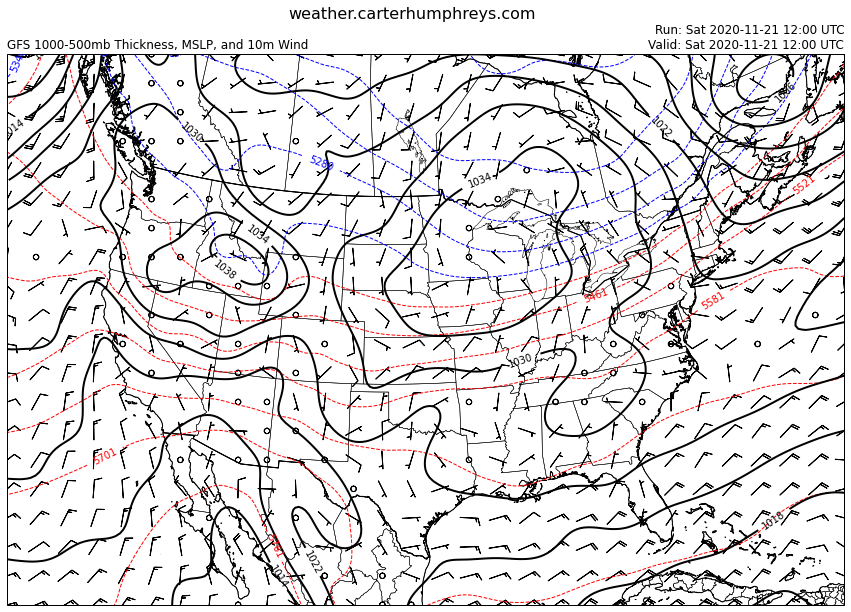

In [4]:
# Set Projection of Data
datacrs = ccrs.PlateCarree()

# Set Projection of Plot
plotcrs = ccrs.LambertConformal(central_latitude=[30, 60], central_longitude=-100)

# Create new figure
fig = plt.figure(figsize=(15, 12.5))
gs = gridspec.GridSpec(2, 1, height_ratios=[1, .02], bottom=.07, top=.99, hspace=0.01, wspace=0.01)

# Add the map and set the extent
ax = plt.subplot(gs[0], projection=plotcrs)
ax.set_extent([235, 290, 20, 55])

# Add state/country boundaries to plot
country_borders=cfeature.NaturalEarthFeature(category='cultural', name='admin_0_countries', scale='10m', facecolor='none')
ax.add_feature(country_borders, edgecolor='black', linewidth=1.0)
state_borders=cfeature.NaturalEarthFeature(category='cultural', name='admin_1_states_provinces_lakes', scale='10m', facecolor='none')
ax.add_feature(state_borders, edgecolor='black', linewidth=0.5)

# Plot Thickness Contours (<=540 line)
clev = np.arange(0, 5400, 60)
cs = ax.contour(ds.lon, ds.lat, thickness, clev, colors='blue', linestyles='--', linewidths=1, transform=datacrs)
plt.clabel(cs, fontsize=10, inline=1, inline_spacing=10, fmt='%i', rightside_up=True, use_clabeltext=True)

# Plot Thickness Contours (>540 line)
clev = np.arange(5401, 10000, 60)
cs = ax.contour(ds.lon, ds.lat, thickness, clev, colors='red', linestyles='--', linewidths=1, transform=datacrs)
plt.clabel(cs, fontsize=10, inline=1, inline_spacing=10, fmt='%i', rightside_up=True, use_clabeltext=True)

# Plot MSLP Contour
clev = np.arange(950, 1040, 4)
cs = ax.contour(ds.lon, ds.lat, mslp, clev, colors='black', linewidths=2, transform=datacrs)
plt.clabel(cs, fontsize=10, inline=1, inline_spacing=10, fmt='%i', rightside_up=True, use_clabeltext=True)

# Plot Wind Barbs
ax.barbs(ds.lon, ds.lat, u.magnitude, v.magnitude, length=6, regrid_shape=20, pivot='middle', transform=datacrs)

# Change datetiem64 to datetime
valid = datetime.utcfromtimestamp(ds.time.values.astype('O')/1e9)

# Add plot headers
plt.title(f'GFS 1000-500mb Thickness, MSLP, and 10m Wind', loc='left')
plt.title(f'Run: {valid.strftime("%a %Y-%m-%d %H:%M")} UTC\nValid: {valid.strftime("%a %Y-%m-%d %H:%M")} UTC', loc='right')

# Add title
plt.suptitle(f'weather.carterhumphreys.com', fontsize=16, x=0.50, y=0.90)
    
# Export plot and close
plt.show()